In [9]:
from pandas import json_normalize
import pip._vendor.requests 
import os
import json
from dotenv import load_dotenv
import csv
import pandas as pd
from datetime import datetime
from operator import itemgetter
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import numpy as np

In [10]:
keyWordData = pd.read_csv('finalAsianKeywords.csv')
words = keyWordData['keyword'].tolist()
keywordQueryString = ""

for word in words:
    if word != words[-1]:
        keywordQueryString = keywordQueryString + word + " OR "
    else:
        keywordQueryString = keywordQueryString + word


In [11]:
load_dotenv()

# To get bearer token environment variable
bearer_token = os.environ.get("BEARER-TOKEN")

search_url = "https://api.twitter.com/2/tweets/counts/all"

# Optional params: start_time,end_time,since_id,until_id,next_token,granularity

def query_params(next_token):

    queryString = f'({keywordQueryString}) lang:en -is:retweet place_country:gb'
    newDict = {'query': queryString, 'granularity': 'day', 'start_time': '2019-01-01T00:00:00Z', 'end_time': '2022-06-01T00:00:00Z', 'next_token': next_token}
    return newDict


    # return {'query': '(asian OR asian indian OR asians OR asiatic OR azn OR brunei OR bruneian OR burma OR burmese OR cambodia OR cambodian OR china OR chinaman OR chinese OR ching chong OR chink OR chinkerbell OR chinks OR cracker jap OR dog eater OR east asian OR east timor OR far eastern OR filipino OR filipinos OR gook OR hong kong OR indonesia OR indonesian OR japan OR japanese OR korean OR koreans OR lao OR laos OR laotian OR macao OR macau OR malaysia OR malaysian OR mongolia OR mongolian OR mongolians OR myanmar OR north korea OR north korean OR oriental OR orientals OR philippines OR singapore OR singaporean OR slant eyed OR south korea OR south korean OR southeast asian OR soyback OR squint nigger OR taiwan OR taiwanese OR thai OR thailand OR tibet OR tibetan OR timorese OR vietnam OR vietnamese) lang:en -is:retweet place_country:gb', 'granularity': 'day', 'start_time': '2019-01-01T00:00:00Z', 'end_time': '2022-06-01T00:00:00Z', 'next_token': next_token}

query_params({})

def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2FullArchiveTweetCountsPython"
    return r

In [12]:
def connect_to_endpoint(url, params):
    response = pip._vendor.requests.request("GET", search_url, auth=bearer_oauth, params=params)
    # print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()


In [13]:
def get_tweet_counts():
    next_token = {}
    finished = False
    while finished == False:
        json_response = connect_to_endpoint(search_url, query_params(next_token))
        if 'next_token' in json_response['meta']:
            # Save the token to use for next call
            next_token = json_response['meta']['next_token']
        else:
            finished = True
    return json_response


get_tweet_counts()

{'data': [{'end': '2019-01-02T00:00:00.000Z',
   'start': '2019-01-01T00:00:00.000Z',
   'tweet_count': 428},
  {'end': '2019-01-03T00:00:00.000Z',
   'start': '2019-01-02T00:00:00.000Z',
   'tweet_count': 481},
  {'end': '2019-01-04T00:00:00.000Z',
   'start': '2019-01-03T00:00:00.000Z',
   'tweet_count': 644},
  {'end': '2019-01-05T00:00:00.000Z',
   'start': '2019-01-04T00:00:00.000Z',
   'tweet_count': 494},
  {'end': '2019-01-06T00:00:00.000Z',
   'start': '2019-01-05T00:00:00.000Z',
   'tweet_count': 426},
  {'end': '2019-01-07T00:00:00.000Z',
   'start': '2019-01-06T00:00:00.000Z',
   'tweet_count': 423},
  {'end': '2019-01-08T00:00:00.000Z',
   'start': '2019-01-07T00:00:00.000Z',
   'tweet_count': 372}],
 'meta': {'total_tweet_count': 3268}}

**the following function that writes tweetcount data to a csv produces results which are not ordered, this problem was fixed in the following function that creates a df**

In [14]:
def get_tweet_counts_to_CSV():
    # using mode "w+"" to truncate the file, if simply want to update (add more rows to) the file use mode "a"
    csvFile = open("tweetCountsAsianKeywordsUnordered.csv", "w+", newline = "", encoding = "utf-8")
    csvWriter = csv.writer(csvFile)

    #creating headers
    csvWriter.writerow(['start', 'tweet count'])

    next_token = {}
    finished = False
   
    while finished == False:
        json_response = connect_to_endpoint(search_url, query_params(next_token))
        # print(json_response)
        for r in json_response['data']:
            start = r['start']
            count = r['tweet_count']
            result = [start, count]
            csvWriter.writerow(result)
            
        if 'next_token' in json_response['meta']:
            # Save the token to use for next call
            next_token = json_response['meta']['next_token']
        else:
            finished = True
    csvFile.close()


get_tweet_counts_to_CSV()

In [15]:
def get_tweet_counts_to_df():
    next_token = {}
    finished = False
    data = []
   
    while finished == False:
        json_response = connect_to_endpoint(search_url, query_params(next_token))
        # print(json_response)
        for r in json_response['data']:
            start = r['start']
            count = r['tweet_count']
            startDate = datetime.strptime(start, '%Y-%m-%dT%H:%M:%S.%f%z')
            result = [startDate, count]
            data.append(result)
            
        if 'next_token' in json_response['meta']:
            # Save the token to use for next call
            next_token = json_response['meta']['next_token']
        else:
            finished = True
    
    sortedData = sorted(data, key=itemgetter(0))

    df = pd.DataFrame(sortedData, columns=['date', 'tweetCount'])
    return df

tweetCountsDf = get_tweet_counts_to_df()


**Savings tweetcounts Dataframe to csv**

In [16]:
tweetCountsDf.to_csv("tweetCountsAsianKeywords.csv", sep='\t', encoding='utf-8', index=False)

In [17]:
print(tweetCountsDf)
total = tweetCountsDf['tweetCount'].sum()
print("Total tweet counts: ")
print(total)

                          date  tweetCount
0    2019-01-01 00:00:00+00:00         428
1    2019-01-02 00:00:00+00:00         481
2    2019-01-03 00:00:00+00:00         644
3    2019-01-04 00:00:00+00:00         494
4    2019-01-05 00:00:00+00:00         426
...                        ...         ...
1242 2022-05-27 00:00:00+00:00         194
1243 2022-05-28 00:00:00+00:00         194
1244 2022-05-29 00:00:00+00:00         193
1245 2022-05-30 00:00:00+00:00         207
1246 2022-05-31 00:00:00+00:00         198

[1247 rows x 2 columns]
Total tweet counts: 
461394


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


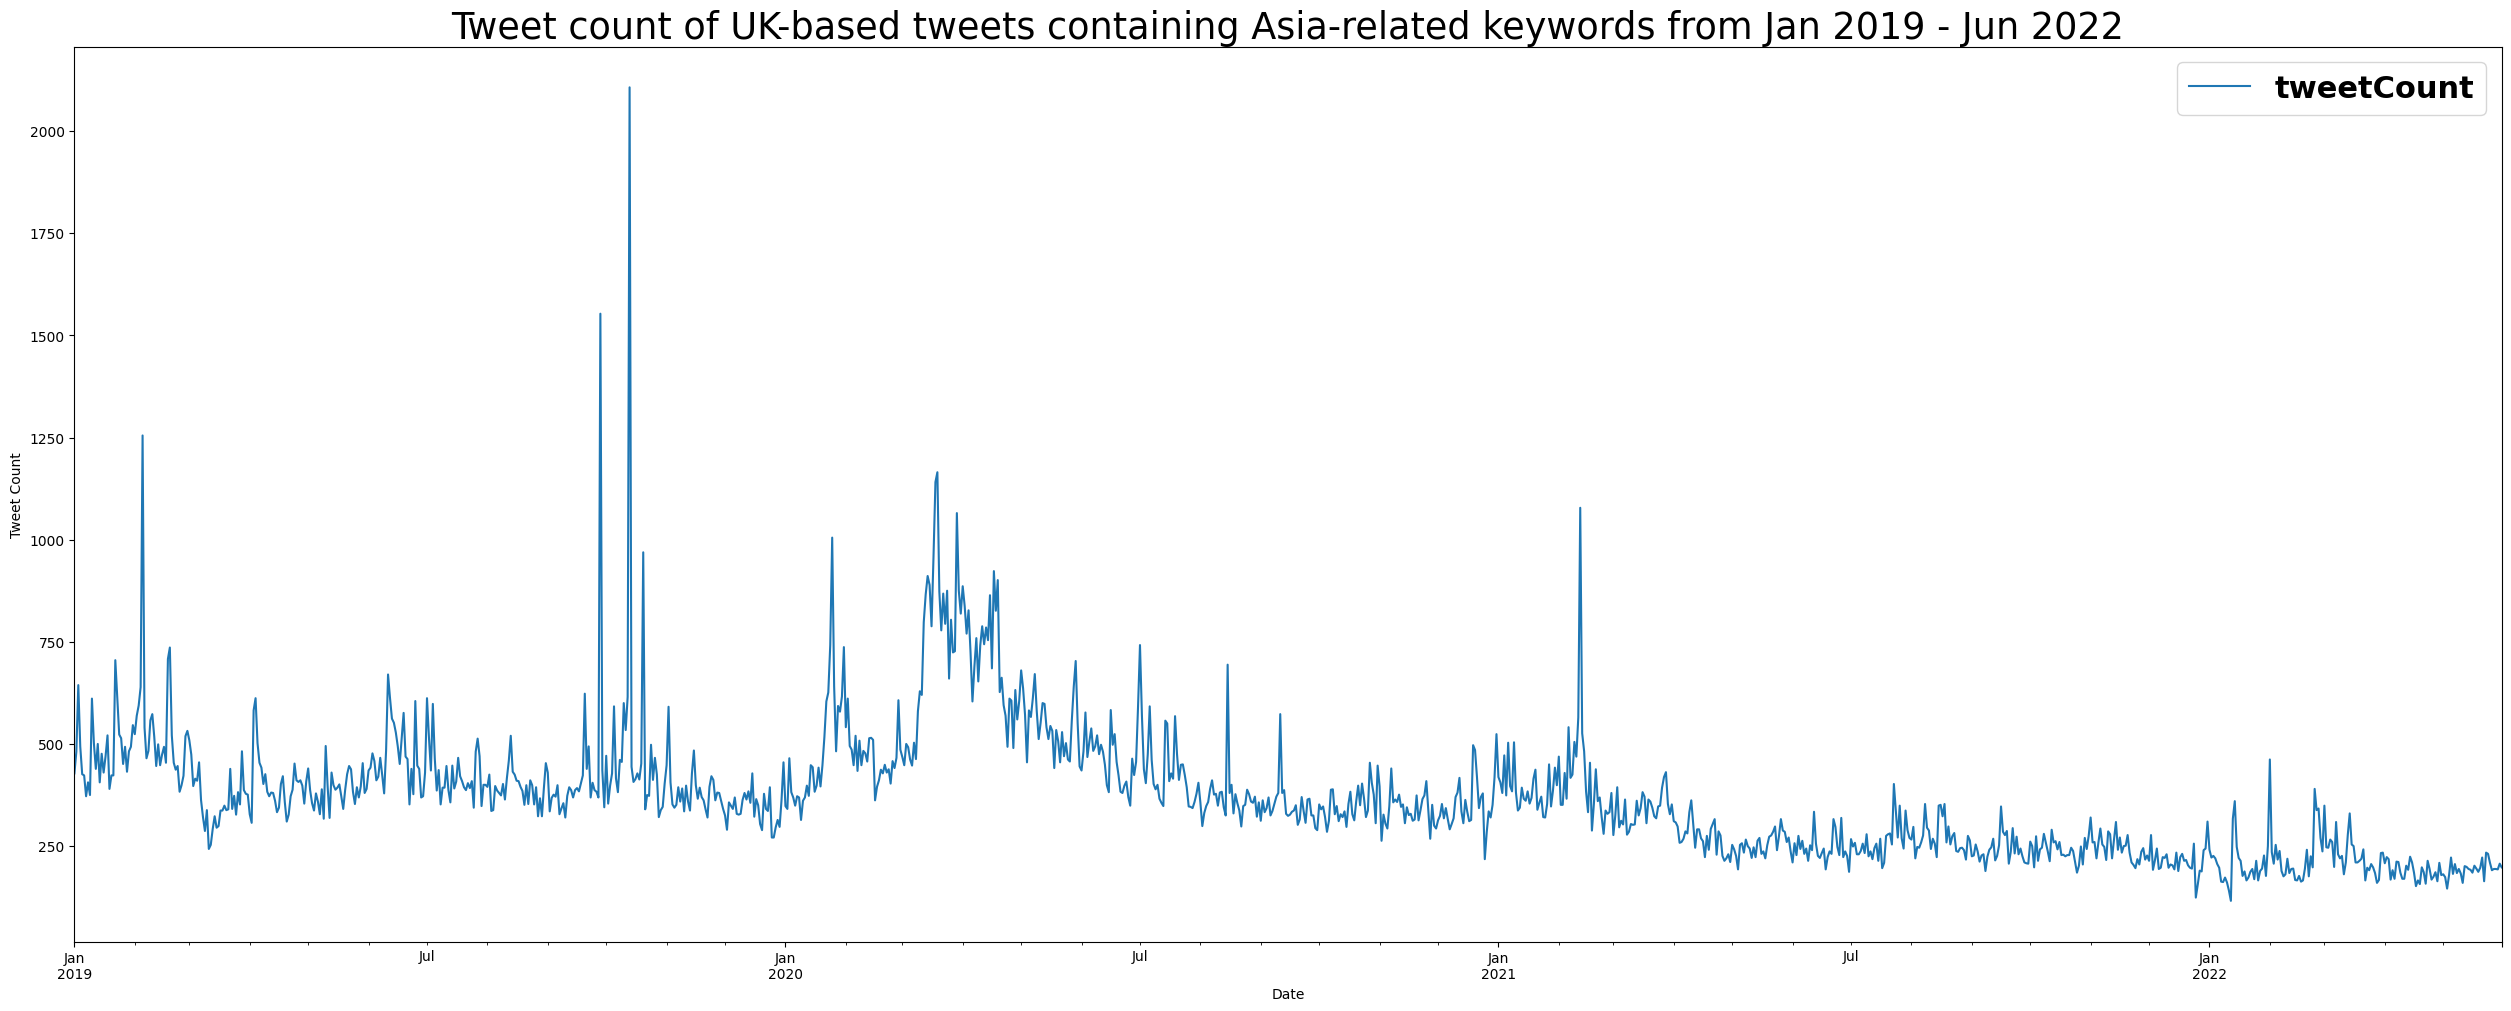

In [18]:
# ax = plt.gca()
fig, ax = plt.subplots(1, 1, figsize= (25, 10), layout ="constrained")
tweetCountsDf.plot(kind='line', x='date', y='tweetCount', ax=ax)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
ax.set_xlabel("Date")
ax.set_ylabel("Tweet Count")
ax.set_title("Tweet count of UK-based tweets containing Asia-related keywords from Jan 2019 - Jun 2022")

ax.legend()

plt.show()